# EURO-LABS 2024: Advanced Training School on Operation of Accelerators
*T. Prebibaj, F. Asvesta

---

# Tracking with Xsuite

Tracking in a real accelerator lattice with the tracking code [Xsuite](https://xsuite.readthedocs.io/en/latest/).

---

In [1]:
# Import xsuite modules and other libraries
import xtrack as xt
import xpart as xp
import xdeps as xd
import xplt

from cpymad.madx import Madx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import nafflib
from scipy.signal import argrelextrema
from scipy.fftpack import fft

## The CERN Proton Synchrotron Booster (PSB)

<p align="center">
<img src=./images_lectures/psb.png width="40%">
</p>

- PSB consists of 4 identical, vertically stacked rings with commin injection and extraction lines. 

- It accelerates protons from $160$ MeV to $2$ GeV in $1.2$ seconds for high-intensity and high-brightness physics. 

- Beam intensities rage from $10^{10}$ to $10^{13}$ protons per ring and the beam emittances from $1$ mm mrad to $15$ mm mrad.

### Exercise 1: load and plot the layout of the PSB

Load the PSB line to Xsuite from the MAD-X sequence and plot it using xplt.

In [2]:
# The MAD-X sequence is at the psb/psb.seq file. The aperture of each element is defined at psb/psb_aperture.dbx
mad = Madx()
mad.options.echo = False # to not print the stdout of MAD-X  
mad.chdir('psb')
mad.call('psb_flat_bottom.madx') # loads the PSB sequence, aperture, etc. in MAD-X
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],
                                 deferred_expressions=True,
                                 allow_thick=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.09.27 09:52:36      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

In [3]:
# Check elements
line_table = line.get_table()
line_table_df = line_table.to_pandas()
line_table_df[0:20]

,s,element_type,name,isthick,isreplica,parent_name,iscollective
0,0.000000,Marker,psb1$start,False,False,None,False
1,0.000000,Marker,p01ring1$start,False,False,None,False
2,0.000000,Drift,drift_0,True,False,None,False
3,0.179500,Bend,bi1.bsw1l1.1,True,False,None,False
4,0.492500,Drift,drift_1,True,False,None,False
5,0.869500,Bend,bi1.bsw1l1.2,True,False,None,False
6,1.194500,Drift,drift_2,True,False,None,False
7,1.327628,Drift,bi1.btv1l1,True,False,None,False
8,1.327628,Drift,drift_3,True,False,None,False
9,1.334000,Drift,bi1.bcsf1l1,True,False,None,False


In [4]:
# Get circumference
print('PSB circumference in meters: ', line.get_length()) 

PSB circumference in meters:  157.07999999999979


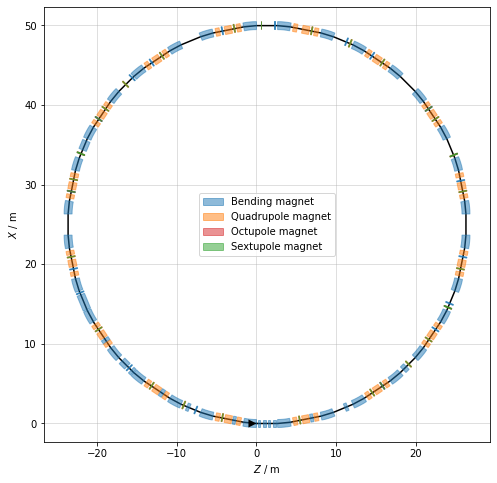

In [5]:
line.build_tracker()
plot = xplt.FloorPlot(line=line, labels="S.Q.", figsize=(8,8))
plot.legend()

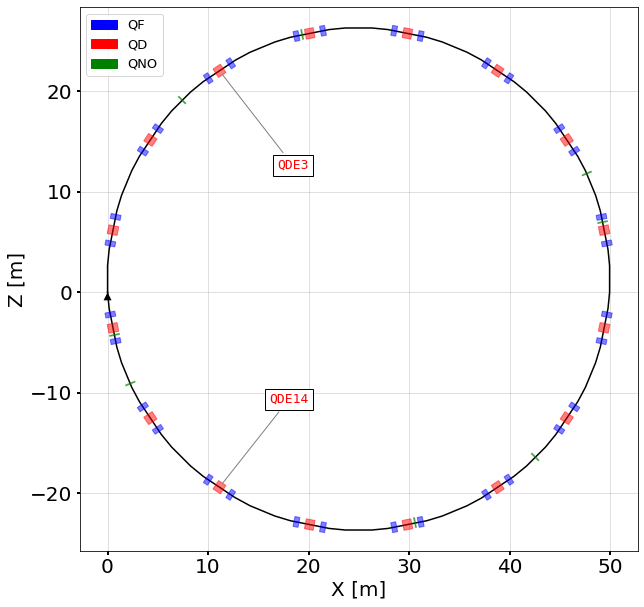

In [20]:
# A fancier plot
import matplotlib.patches as mpatches
plot = xplt.FloorPlot(line=line, projection="XZ", figsize=(10, 10),
            boxes={
                "br.qfo": dict(color="blue"),
                "br.qde": dict(color="red"),      
                "br1.qno": dict(color="green"), 
            },
            labels={
                "S.Q.": True,  # Default labels
                "br.qde3": dict(text=('QDE3'),xytext=(20, 12),
                                bbox={"fc": "white"},font="monospace",c="red",fontsize=13),
                "br.qde14": dict(text=('QDE14'),xytext=(20, -10),
                                 bbox={"fc": "white"},font="monospace",c="red",fontsize=13),
                },
)
#plot.add_scale(fontsize=15)
plot.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
plot.ax.set_xlabel("X [m]", fontsize=20)
plot.ax.set_ylabel("Z [m]", fontsize=20)
legend_handles = [
    mpatches.Patch(color="blue", label=r"QF"),
    mpatches.Patch(color="red", label=r"QD"),
    mpatches.Patch(color="green", label=r"QNO"),
]
plot.legend(loc="upper left", fontsize=13, handles=legend_handles) 

- The PSB ring consists of 16 identical cells with a total circumference of $157.08$ meters (relatively similar with the cases we have seen so far).

- Each cell (or period or sector) consists of one defocusing and two focusing quadrupoles, two dipoles and many higher order magnets (sextupoles, octupoles, etc). 

### Exercise 2: optics functions of PSB

Use the line.twiss() method of Xsuite to compute the optics functions around the PSB and plot them.

In [6]:
# We need to add a reference particle for the twiss calculation (mass, energy)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
print('Reference particle added at gamma0=%s.'%(mad.sequence.psb1.beam.gamma))

line.twiss_default['method'] = '4d' # to ignore the longitudinal plane
twiss = line.twiss()
twiss_df = twiss.to_pandas()

Reference particle added at gamma0=1.1705262269290748.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [7]:
# This is the twiss table
twiss_df[['s', 'betx', 'alfx', 'gamx', 'mux', 'dx', 'bety', 'alfy', 'gamy', 'muy', 'dy']]

,s,betx,alfx,gamx,mux,dx,bety,alfy,gamy,muy,dy
0,0.0000,5.632690,0.250691,0.188692,0.000000,-1.311375,4.296431,0.345255,0.260495,0.000000,-0.0
1,0.0000,5.632690,0.250691,0.188692,0.000000,-1.311375,4.296431,0.345255,0.260495,0.000000,-0.0
2,0.0000,5.632690,0.250691,0.188692,0.000000,-1.311375,4.296431,0.345255,0.260495,0.000000,-0.0
3,0.1795,5.548771,0.216821,0.188692,0.005111,-1.311366,4.180877,0.298496,0.260495,0.006743,0.0
4,0.1795,5.548771,0.216821,0.188692,0.005111,-1.311366,4.180877,0.298496,0.260495,0.006743,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1218,157.0800,5.632690,0.318027,0.195491,4.400000,-1.311375,4.296431,0.296161,0.253166,4.450000,0.0
1219,157.0800,5.632690,0.250691,0.188692,4.400000,-1.311375,4.296431,0.345255,0.260495,4.450000,0.0
1220,157.0800,5.632690,0.250691,0.188692,4.400000,-1.311375,4.296431,0.345255,0.260495,4.450000,0.0
1221,157.0800,5.632690,0.250691,0.188692,4.400000,-1.311375,4.296431,0.345255,0.260495,4.450000,0.0


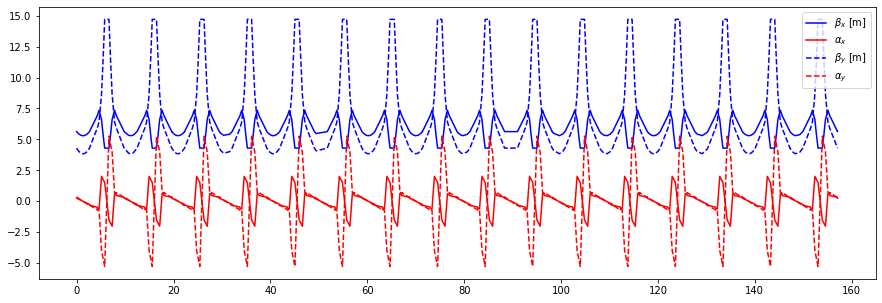

In [8]:
plt.figure(figsize=(15,5))
plt.plot(twiss_df['s'], twiss_df['betx'], label=r'$\beta_x$ [m]', c='blue')
plt.plot(twiss_df['s'], twiss_df['alfx'], label=r'$\alpha_x$', c='red')
plt.plot(twiss_df['s'], twiss_df['bety'], label=r'$\beta_y$ [m]', c='blue', ls='--')
plt.plot(twiss_df['s'], twiss_df['alfy'], label=r'$\alpha_y$', c='red', ls='--')
plt.legend()


### Exercise 3: matching the tunes

In PSB, all the focusing quadrupoles are powered in series which means all of them can have the same strength. Same applies for the defocusing quadrupoles. The strength of the focusing quadrupoles is conventionally named as "kbrqf" while for the defocusing "kbrqd". 

Xsuite has algorithms to calculate the quadrupole strengths in order to achieve our desired optics constrains (for example a certain tune, an upper limit for the beta-function etc.). This process is known as optics matching. 

In this exercise, vary the quadrupole strength to match the transverse betatron tunes to $(Q_x,Q_y)=(4.17,4.23)$ using the `line.match` command of Xsuite. 

In [9]:
# The initial lattice gives the following tunes
print('Qx = ', twiss.qx)
print('Qy = ', twiss.qy)

Qx =  4.399999999756882
Qy =  4.450000000567766


In [10]:
# Here we vary the strength of the quadrupoles (two knobs) to reach the target tunes (two constraints)
# The matching process is not always possible..
line.match(
      vary=[
            xt.Vary('kbrqf', step=1e-8),
            xt.Vary('kbrqd', step=1e-8),
      ],
      targets = [
                  xt.Target('qx', 4.17, tol=1e-5),
                  xt.Target('qy', 4.23, tol=1e-5)
      ]
)

Matching: model call n. 8       



In [11]:
# We re-twiss the latice
twiss_after = line.twiss()
twiss_after_df = twiss_after.to_pandas()
print('Horizontal tune after the matching Qx = ', twiss_after.qx)
print('Vertical tune after the matching Qy = ', twiss_after.qy)

Horizontal tune after the matching Qx =  4.170001792569275
Vertical tune after the matching Qy =  4.230003706158103


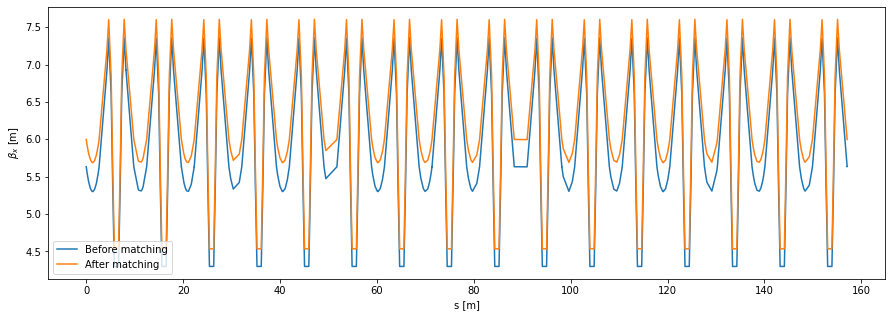

In [12]:
# The beta-function changed in the new configuration of the quadrupoles
plt.figure(figsize=(15,5))
plt.plot(twiss_df['s'], twiss_df['betx'], label='Before matching')
plt.plot(twiss_after_df['s'], twiss_after_df['betx'], label='After matching')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_x$ [m]')
plt.legend()

#### Try at home: iteratively match the lattice to Qx from 4.1 to 4.4 by keeping the Qy constant at 4.23 and plot the beta_x function at the beginning of the lattice as a function of Qx. How much do the optics change for the different horizontal tunes?

### Exercise 4: tracking in the PSB

- Generate a matched Guassian distribution of $1000$ particles and track it for one turn in the PSB lattice. Plot the particle trajectories along the ring in the vertical plane (y). 

- Track the same distribution for $1000$ turns (without saving the particle state at all PSB elements). How long did it take?


In [13]:
# Xsuite tracks in 3D, so we need to add a voltage to the RF cavity to simulate the longitudinal motion
line.element_refs['br.c02'].voltage = 0.008*1e6
print('Constant voltage = 8 kV added to the dummy RF.')

particles = xp.generate_matched_gaussian_bunch(num_particles=1000,
                                total_intensity_particles=1e10,
                                nemitt_x=1e-6, nemitt_y=1e-6, sigma_z=10,
                                particle_ref=line.particle_ref,
                                line=line
                                )

Constant voltage = 8 kV added to the dummy RF.
*** Maximum RMS bunch length 24.692096598476212m.


/home/tprebiba/python_environments/base-2022/miniconda/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -9.8998e+00
... distance to target bunch length: 1.4070e+01
... distance to target bunch length: 1.0223e+01
... distance to target bunch length: 6.1652e-01
... distance to target bunch length: -6.3193e-02
... distance to target bunch length: -5.7318e-04
... distance to target bunch length: 8.3483e-09
... distance to target bunch length: -5.5011e-05
--> Bunch length: 10.00000000834825
--> Emittance: 0.23228237555785303


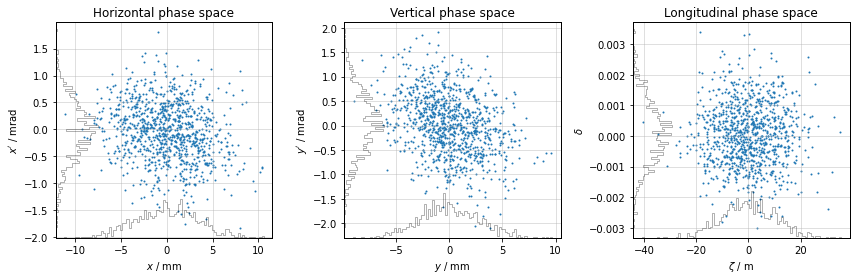

In [14]:
plot = xplt.PhaseSpacePlot(particles)
plot.fig.tight_layout()

In [15]:
# Tracking for one turn but saving the particle distribution at all PSB elements
line.track(particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE') # to save in all elements

Text(0, 0.5, 'y [mm]')

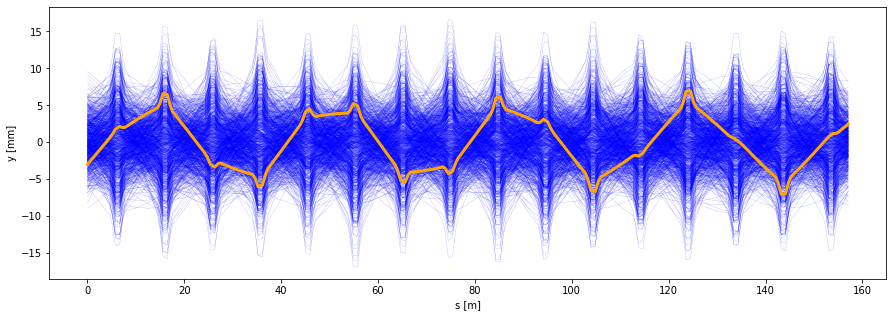

In [16]:
# Plotting the particle trajectories in y
plt.figure(figsize=(15,5))
for i in range(1000):
    plt.plot(line.record_last_track.s[0], line.record_last_track.y[i]*1e3, '-', lw=0.1, c='blue')
plt.plot(line.record_last_track.s[0], line.record_last_track.y[0]*1e3, '-', lw=3, c='orange', label='Single particle trajectory')
plt.xlabel('s [m]')
plt.ylabel('y [mm]')

In [17]:
import time
start = time.time()
line.track(particles, num_turns=1000)
end = time.time()
print('Tracking time for 1000 turns = ', end-start, ' seconds')
print('Tracking time per turn per particle = ', (end-start)/(1000*1000)*1e6, 'microseconds')

Tracking time for 1000 turns =  9.322081089019775  seconds
Tracking time per turn per particle =  9.322081089019775 microseconds


### Exercise 5: reconstruct tune from turn-by-turn data

- Match the PSB lattice to the working point of $(Q_x, Q_y)=(4.403, 4.453)$  and track a single particle for 800 turns. 

- Do an FFT analysis to calculate the tune from the turn-by-turn data (you can use scipy.fft or NAFFlib)

- Add some noise to the TbT beam position and re-do the FFT.

In [18]:
# The MAD-X sequence is at the psb/psb.seq file. The aperture of each element is defined at psb/psb_aperture.dbx
mad = Madx()
mad.options.echo = False # to not print the stdout of MAD-X  
mad.chdir('psb')
mad.call('psb_flat_bottom.madx') # loads the PSB sequence, aperture, etc. in MAD-X
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],
                                 deferred_expressions=True,
                                 allow_thick=True)

# We need to add a reference particle for the twiss calculation (mass, energy)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
print('Reference particle added at gamma0=%s.'%(mad.sequence.psb1.beam.gamma))

# Xsuite tracks in 3D, so we need to add a voltage to the RF cavity to simulate the longitudinal motion
line.element_refs['br.c02'].voltage = 0.008*1e6
print('Constant voltage = 8 kV added to the dummy RF.')

Qx0 = 4.403
Qy0 = 4.453
# Here we vary the strength of the quadrupoles (two knobs) to reach the target tunes (two constraints)
# The matching process is not always possible..
line.match(
      vary=[
            xt.Vary('kbrqf', step=1e-8),
            xt.Vary('kbrqd', step=1e-8),
      ],
      targets = [
                  xt.Target('qx', Qx0, tol=1e-5),
                  xt.Target('qy', Qy0, tol=1e-5)
      ]
)

twiss = line.twiss()
twiss_df = twiss.to_pandas()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.06.05 09:46:52      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

Reference particle added at gamma0=1.1705262269290748.
Constant voltage = 8 kV added to the dummy RF.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 4       



In [19]:
# Built a set of three particles with different y coordinates
# (context and particle_ref are taken from the line)
particles = line.build_particles(x = [0.5e-3], y=[1e-3]) # single particle at x=0.5 mm, y=1 mm

num_turns = 800
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)

x_tbt = line.record_last_track.x[0]
y_tbt = line.record_last_track.y[0]

Text(0, 0.5, 'Amplitude [mm]')

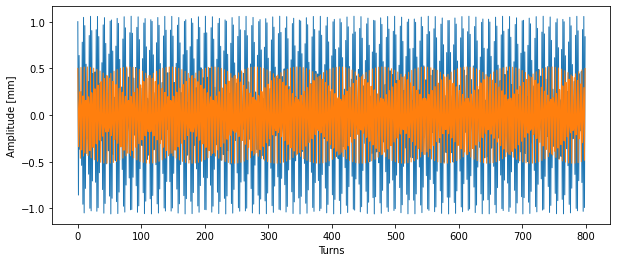

In [20]:
# Plotting turn-by-turn data for the two planes
plt.figure(figsize=(10,4))
plt.plot(y_tbt*1e3, linewidth=1)
plt.plot(x_tbt*1e3, linewidth=1)
plt.xlabel('Turns')
plt.ylabel('Amplitude [mm]')

In [21]:
# spectrum using scipy
data = np.array(y_tbt) # focusing only in the y-plane
N = len(data)
freqs = np.linspace(0,1,N)
ampls = fft(data)
tunes = freqs[:N//2]
norm_ampls = abs(ampls[:N//2])/np.max(abs(ampls))
maximas = argrelextrema(norm_ampls, np.greater)
inds = norm_ampls[maximas].argsort()
max_ampls = norm_ampls[maximas][inds][::-1]
max_tunes = tunes[maximas][inds][::-1]

# spectrum using NAFFlib
norder = 3 # number of the most dominant frequencies
qs, A, B = nafflib.get_tunes(data, norder)

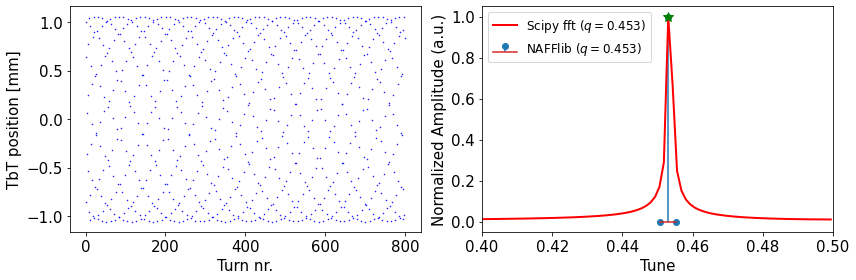

In [22]:
f,axs = plt.subplots(1,2,figsize=(12,4))
fontsize=15

ax = axs[0]
ax.set_xlabel('Turn nr.', fontsize=fontsize)
ax.set_ylabel('TbT position [mm]', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(data*1e3, '.', ms=1.0, c='blue')

ax = axs[1]
ax.set_xlabel('Tune', fontsize=fontsize)
ax.set_ylabel('Normalized Amplitude (a.u.)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.stem(qs, abs(A/np.max(A)), label='NAFFlib ($q=%1.3f$)'%qs[0])
ax.plot(tunes, norm_ampls, '-', c='red', lw=2.0, label='Scipy fft ($q=%1.3f$)'%max_tunes[0])
ax.plot(max_tunes[0:1], max_ampls[0:1], '*', ms=10, color='green')
ax.legend(loc=0, fontsize=fontsize-3)
ax.set_xlim(0.4,0.5)

f.tight_layout()
plt.show()


In [23]:
# Adding errors in the turn-by-turn data
data2 = data + 1e-3*np.random.randn(len(data)) # noise
#data2 = 1.05*data2 # 5 percent calibration error


# spectrum using scipy
N = len(data2)
freqs = np.linspace(0,1,N)
ampls = fft(data2)
tunes = freqs[:N//2]
norm_ampls = abs(ampls[:N//2])/np.max(abs(ampls))
maximas = argrelextrema(norm_ampls, np.greater)
inds = norm_ampls[maximas].argsort()
max_ampls = norm_ampls[maximas][inds][::-1]
max_tunes = tunes[maximas][inds][::-1]

# spectrum using NAFFlib
norder = 3 # number of the most dominant frequencies
qs, A, B = nafflib.get_tunes(data2, norder)

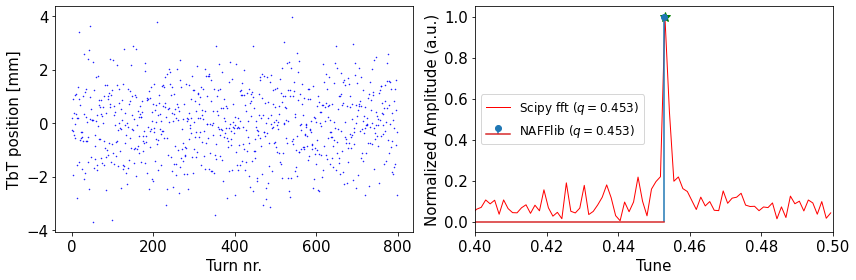

In [24]:
f,axs = plt.subplots(1,2,figsize=(12,4))
fontsize=15

ax = axs[0]
ax.set_xlabel('Turn nr.', fontsize=fontsize)
ax.set_ylabel('TbT position [mm]', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(data2*1e3, '.', ms=1.0, c='blue')

ax = axs[1]
ax.set_xlabel('Tune', fontsize=fontsize)
ax.set_ylabel('Normalized Amplitude (a.u.)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot(tunes, norm_ampls, '-', c='red', lw=1.0, label='Scipy fft ($q=%1.3f$)'%max_tunes[0])
ax.plot(max_tunes[0:1], max_ampls[0:1], '*', ms=10, color='green')
ax.stem(qs, abs(A/np.max(A)), label='NAFFlib ($q=%1.3f$)'%qs[0])
ax.legend(loc=0, fontsize=fontsize-3)
ax.set_xlim(0.4,0.5)

f.tight_layout()
plt.show()


### Exercise 6: motion near a quadrupolar resonance - beta-beating

- Match the PSB lattice to the working point of $(Q_x, Q_y)=(4.403, 4.49)$ and save the twiss table.

- Add a quadrupole error (impoerfection) in the lattice. You can do that by power the QNO816 quadrupoles with an integrated strength of 0.0045 (line variable name "kbr1qno816l3").

- Re-twiss and compare the vertical beta functino ('bety') with the initial twiss table. What do you observe?

- Generate a matched Guassian distribution of $1000$ particles and track it for one turn in the PSB lattice. Plot the particle trajectories along the ring in the vertical plane (y). What do you observe?

In [25]:
# Loading and matching the PSB lattice
mad = Madx()
mad.options.echo = False
mad.chdir('psb')
mad.call('psb_flat_bottom.madx')
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],deferred_expressions=True,allow_thick=True)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
line.element_refs['br.c02'].voltage = 0.008*1e6
Qx0 = 4.403
Qy0 = 4.49
line.match(vary=[xt.Vary('kbrqf', step=1e-8),xt.Vary('kbrqd', step=1e-8)],
           targets = [xt.Target('qx', Qx0, tol=1e-5),xt.Target('qy', Qy0, tol=1e-5)])
line.element_refs['br.c02'].voltage = 0.008*1e6 # for the tracking later
twiss = line.twiss()
twiss_before = twiss.to_pandas()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.06.05 09:47:02      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 8       



In [26]:
# Assigning the quadrupolar error to the lattice
line.vars['kbr1qno816l3'] = 0.0045

In [27]:
# Re-twissing after the error
twiss = line.twiss()
twiss_after = twiss.to_pandas()

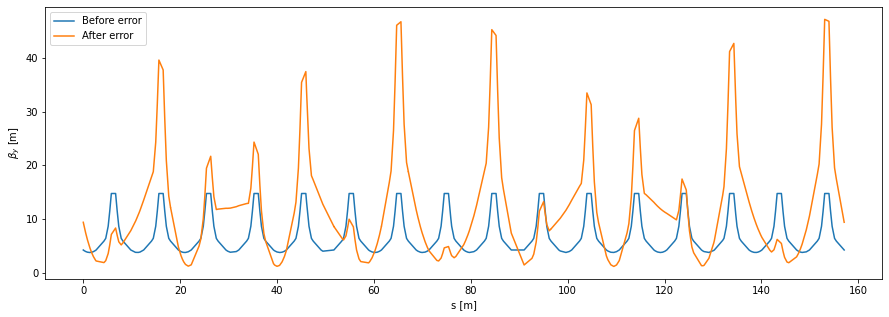

In [28]:
# Plotting the beta functions before and after the error
plt.figure(figsize=(15,5))
plt.plot(twiss_before['s'], twiss_before['bety'], label='Before error')
plt.plot(twiss_after['s'], twiss_after['bety'], label='After error')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_y$ [m]')
plt.legend()

> Note: the quadrupolar error perturbed the vertical beta-function. This effect is known as beta-beating and is particularly enhanced when the tune is near a half-integer value (here Qy=4.49 close to 4.5).

In [29]:
# generate matched distribution
particles = xp.generate_matched_gaussian_bunch(num_particles=1000,
                                total_intensity_particles=1e10,
                                nemitt_x=1e-6, nemitt_y=1e-6, sigma_z=10,
                                particle_ref=line.particle_ref,
                                line=line
                                )

*** Maximum RMS bunch length 24.6920965984762m.


/home/tprebiba/python_environments/base-2022/miniconda/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -9.8998e+00
... distance to target bunch length: 1.4070e+01
... distance to target bunch length: 1.0223e+01
... distance to target bunch length: 6.1652e-01
... distance to target bunch length: -6.3193e-02
... distance to target bunch length: -5.7318e-04
... distance to target bunch length: 8.3483e-09
... distance to target bunch length: -5.5011e-05
--> Bunch length: 10.000000008348257
--> Emittance: 0.23119125014066877


In [30]:
# Tracking for one turn but saving the particle distribution at all PSB elements
line.track(particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE') # to save in all elements

Text(0, 0.5, 'y [mm]')

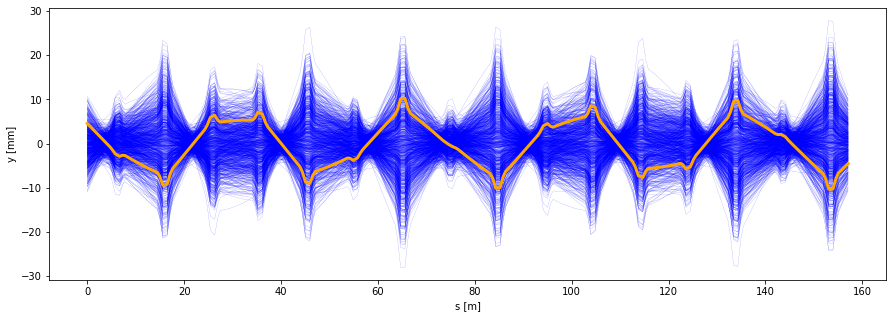

In [31]:
# Plotting the particle trajectories in y
plt.figure(figsize=(15,5))
for i in range(1000):
    plt.plot(line.record_last_track.s[0], line.record_last_track.y[i]*1e3, '-', lw=0.1, c='blue')
plt.plot(line.record_last_track.s[0], line.record_last_track.y[0]*1e3, '-', lw=3, c='orange', label='Single particle trajectory')
plt.xlabel('s [m]')
plt.ylabel('y [mm]')

> Note how perturbed is the motion of the particles in the y-plane after the quadrupolar error. 

#### For home: plot the RMS vertical beta-beating as a function of the Qy which ranges from 4.2 to 4.49. What do you observe?

#### For home: add a dipolar error to the lattice (you could add some value to the strength of a vertical dipole corrector, i.e. kbr1dvt3l4) and notice the closed orbit distortions. How does the closed orbit distortion change with different working points? What happens close to an integer tune (i.e. Qy=4.0) and what close to a half-integer tune (i.e. Qy=4.5)?

### Exercise 7: motion on a quadrupolar resonance - phase space

- From the previous example, track a single particle for 800 turns and plot the vertical phase space (**phase space near a resonance**).

- Re-match the lattice at $(Q_x, Q_y)=(4.23, 4.17)$, re-track for 800 turns and plot the same phase space (**phase space far from a resonance**). 

- Re-match the lattice at $(Q_x, Q_y)=(4.40, 4.495)$, re-track for 800 turns and plot the same phase space (**phase space on a resonance**). 

In [32]:
# Rematching the tunes to (Qx,Qy) = (4.403,4.49)
line.vars['kbr1qno816l3'] = 0.0
line.match(vary=[xt.Vary('kbrqf', step=1e-8),xt.Vary('kbrqd', step=1e-8)],
           targets = [xt.Target('qx', 4.403, tol=1e-5), xt.Target('qy', 4.49, tol=1e-5)])
line.vars['kbr1qno816l3'] = 0.0045
particles = line.build_particles(x = [0.5e-3], y=[1e-3]) # single particle at x=0.5 mm, y=1 mm
num_turns = 800
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
y_tbt = line.record_last_track.y[0]
py_tbt = line.record_last_track.py[0]

Matching: model call n. 1       



Text(0, 0.5, 'py [mrad]')

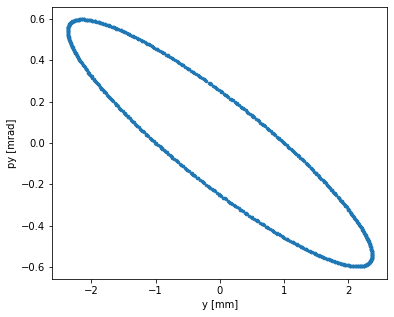

In [33]:
plt.figure(figsize=(6,5))
plt.plot(y_tbt*1e3, py_tbt*1e3, '.', ms=5)
plt.xlabel('y [mm]')
plt.ylabel('py [mrad]')

> Note: phase space near a resonance is stable but perturbed.

In [34]:
# Rematching the tunes to (Qx,Qy) = (4.17,4.23)
line.vars['kbr1qno816l3'] = 0.0
line.match(vary=[xt.Vary('kbrqf', step=1e-8),xt.Vary('kbrqd', step=1e-8)],
           targets = [xt.Target('qx', 4.17, tol=1e-5), xt.Target('qy', 4.23, tol=1e-5)])
line.vars['kbr1qno816l3'] = 0.0045
# Retracking
particles = line.build_particles(x = [0.5e-3], y=[1e-3]) # single particle at x=0.5 mm, y=1 mm
num_turns = 800
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
y_tbt = line.record_last_track.y[0]
py_tbt = line.record_last_track.py[0]

Matching: model call n. 8       



Text(0, 0.5, 'py [mrad]')

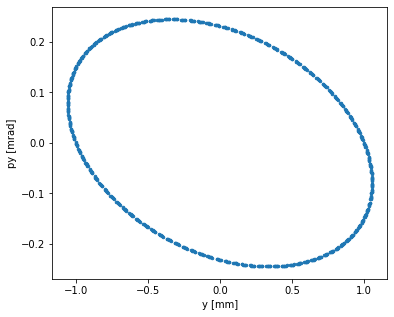

In [35]:
plt.figure(figsize=(6,5))
plt.plot(y_tbt*1e3, py_tbt*1e3, '.', ms=5)
plt.xlabel('y [mm]')
plt.ylabel('py [mrad]')

> Note: phase space far from the resonance is not pertubed.

In [36]:
# Rematching the tunes to (Qx,Qy) = (4.403,4.493)
line.vars['kbr1qno816l3'] = 0.0
line.match(vary=[xt.Vary('kbrqf', step=1e-8),xt.Vary('kbrqd', step=1e-8)],
           targets = [xt.Target('qx', 4.403, tol=1e-5), xt.Target('qy', 4.493, tol=1e-5)])
line.vars['kbr1qno816l3'] = 0.0045
# Retracking
particles = line.build_particles(x = [0.5e-3], y=[1e-3]) # single particle at x=0.5 mm, y=1 mm
num_turns = 800
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
y_tbt = line.record_last_track.y[0]
py_tbt = line.record_last_track.py[0]

Matching: model call n. 12       



Text(0, 0.5, 'py [mrad]')

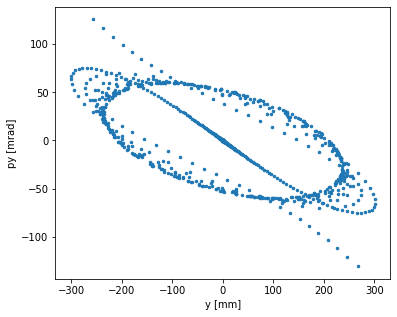

In [37]:
plt.figure(figsize=(6,5))
plt.plot(y_tbt*1e3, py_tbt*1e3, '.', ms=5)
plt.xlabel('y [mm]')
plt.ylabel('py [mrad]')

> Note: the phase space is unstable on the resonance.

### Exercise 8: Transverse painting

The transverse painting is a technique to uniformly fill the phase space in order to intentionally make the beam larger and more uniform in order to reduce the space charge. 

In the PSB, the transverse painting is performed by applying an offset between the injected beam and the closed orbit. This offset can be constant or it can change turn-by-turn (remember in the PSB we can inject over many turns).

In this exercise, we will implement a transverse painting scheme for the PSB. 

In [38]:
# First we load and match the PSB lattice to a certain working point 
mad = Madx()
mad.options.echo = False
mad.chdir('psb')
mad.call('psb_flat_bottom.madx')
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],deferred_expressions=True,allow_thick=True)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
line.element_refs['br.c02'].voltage = 0.008*1e6
Qx0 = 4.17
Qy0 = 4.23
line.match(vary=[xt.Vary('kbrqf', step=1e-8),xt.Vary('kbrqd', step=1e-8)],
           targets = [xt.Target('qx', Qx0, tol=1e-5),xt.Target('qy', Qy0, tol=1e-5)])
line.element_refs['br.c02'].voltage = 0.008*1e6 # for the tracking later


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.06.05 09:47:25      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 8       



In [39]:
# The PSB lattice in the MAD-X sequence starts at the beggining of the first sector (out of the 16 sectors). 
# The injection foil is in the middle of the straight section of the first sector.
# To be precise we shift the start of our lattice to the foil (bi1.tstr1l1).
line.discard_tracker() # We need to discard the tracker to edit the line
line.cycle(name_first_element = 'bi1.tstr1l1', inplace=True)
line.build_tracker()
print('Changed line starting point to bi1.tstr1l1 (foil).')

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Changed line starting point to bi1.tstr1l1 (foil).


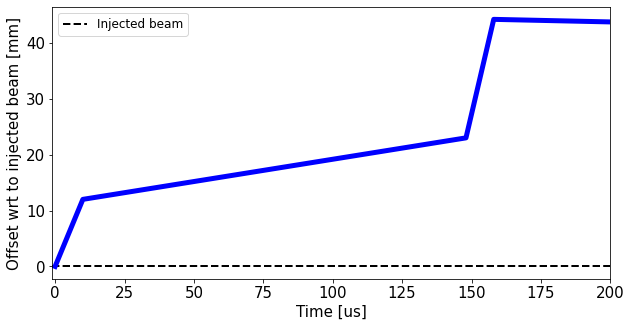

In [40]:
# Here we will generate the shift in the closed orbit or the painting functions
# The function that is defined here is an ISOLDE-like painting
# We can change these functions however we like
p = {}
p['KSW_time_sec'] =         np.array([ 0.0e-6,  10e-6,  148e-6,    158e-6,  1000e-6]) # time in seconds, 1e-6 s is approximately 1 turn in the PSB
p['KSW_bump_amplitude_m'] = np.array([-35e-3,  -23e-3,  -12e-3,    9.2e-3,      0.0]) # the amplitude of the bump in meters

f,ax = plt.subplots(1,1,figsize=(10,5))
fontsize=15
ax.set_xlabel('Time [us]', fontsize=fontsize)
ax.set_ylabel('Offset wrt to injected beam [mm]', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

ax.axhline(0, color='black', ls='--', lw=2.0, label='Injected beam')
ax.plot(p['KSW_time_sec']*1e6, (p['KSW_bump_amplitude_m']-p['KSW_bump_amplitude_m'][0])*1e3, '-', lw=5, color='blue')

ax.set_xlim(-1, 200)
ax.legend(loc=0, fontsize=fontsize-3)

In [41]:
# We will add the painting functions to the line

# the maximum bump amplitude in meters
X_BUMP = -3.5000000000e-02

# The corresponding strengths of the kickers that produce the bump
kbi1ksw1l40 = 5.1720959073e-03   
kbi1ksw2l10 = 1.3941261670e-02   
kbi1ksw16l10 = 1.6031186470e-02   
kbi1ksw16l40 = 3.7937180185e-03

# the length of the kickers
ksw_length = 0.37 # m, 

# Adding the painting function to these parameters
kbi1ksw1l4 = (-1)*p['KSW_bump_amplitude_m']/X_BUMP*kbi1ksw1l40*ksw_length
kbi1ksw2l1 = (-1)*p['KSW_bump_amplitude_m']/X_BUMP*kbi1ksw2l10*ksw_length
kbi1ksw16l1 = (-1)*p['KSW_bump_amplitude_m']/X_BUMP*kbi1ksw16l10*ksw_length
kbi1ksw16l4 = (-1)*p['KSW_bump_amplitude_m']/X_BUMP*kbi1ksw16l40*ksw_length

# Creating functions over time
line.functions['fun_kbiksw1l4'] = xd.FunctionPieceWiseLinear(x=p['KSW_time_sec'], y=kbi1ksw1l4)
line.functions['fun_kbiksw2l1'] = xd.FunctionPieceWiseLinear(x=p['KSW_time_sec'], y=kbi1ksw2l1)
line.functions['fun_kbiksw16l1'] = xd.FunctionPieceWiseLinear(x=p['KSW_time_sec'], y=kbi1ksw16l1)
line.functions['fun_kbiksw16l4'] = xd.FunctionPieceWiseLinear(x=p['KSW_time_sec'], y=kbi1ksw16l4)

# Assigning the functions to the knobs
line.vars['kbi1ksw1l4'] = line.functions.fun_kbiksw1l4(line.vars['t_turn_s'])
line.vars['kbi1ksw2l1'] = line.functions.fun_kbiksw2l1(line.vars['t_turn_s'])
line.vars['kbi1ksw16l1'] = line.functions.fun_kbiksw16l1(line.vars['t_turn_s'])
line.vars['kbi1ksw16l4'] = line.functions.fun_kbiksw16l4(line.vars['t_turn_s'])
print('Knobs built to control KSW bump.')
print('Variable "on_painting_bump" added to control KSW bump.')
print('Time dependence added to kbi1ksw1l4, kbi1ksw2l1, kbi1ksw16l1 and kbi1ksw16l4.')

Knobs built to control KSW bump.
Variable "on_painting_bump" added to control KSW bump.
Time dependence added to kbi1ksw1l4, kbi1ksw2l1, kbi1ksw16l1 and kbi1ksw16l4.


In [42]:
print('Twissing.')
tw = line.twiss()
#tw = line.twiss(co_search_at='psb1$start') # closed orbit at PSB start, otherwise need to give co_guess (xtrack 0.52.0)
co_x_at_foil = tw['x', 'bi1.tstr1l1']
co_y_at_foil = tw['y', 'bi1.tstr1l1']
print('Closed orbit at foil: x = %s m, y = %s m.'%(co_x_at_foil, co_y_at_foil))

Twissing.
Closed orbit at foil: x = -0.041748323127818086 m, y = -2.869028808442999e-32 m.


In [44]:
n_part = 20000
particles2inject = xp.generate_matched_gaussian_bunch(n_part,
                        total_intensity_particles=1e10,
                        nemitt_x=1e-6, nemitt_y=1e-6, sigma_z=10,
                        particle_ref=line.particle_ref,
                        line=line
                        )

*** Maximum RMS bunch length 24.69209659847619m.
... distance to target bunch length: -9.8998e+00
... distance to target bunch length: 1.4070e+01
... distance to target bunch length: 1.0223e+01
... distance to target bunch length: 6.1652e-01
... distance to target bunch length: -6.3193e-02
... distance to target bunch length: -5.7318e-04
... distance to target bunch length: 8.3483e-09
... distance to target bunch length: -5.5011e-05
--> Bunch length: 10.000000008348254
--> Emittance: 0.232362534228249


In [45]:
# Build and insert multi-turn injection element 
num_injections = 150
print('Building and inserting multi-turn injection element to PSB lattice.')
print('Number of injections: ', num_injections)
print('Number of macroparticles per injection: ', int(n_part/num_injections))
p_injection = xt.ParticlesInjectionSample(particles_to_inject=particles2inject,
                                            line=line,
                                            element_name='injection',
                                            num_particles_to_inject=int(n_part/num_injections))
line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=p_injection, name='injection')
line.build_tracker()

Building and inserting multi-turn injection element to PSB lattice.
Number of injections:  150
Number of macroparticles per injection:  133
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [46]:
# Generate particle object with unallocated space (to be filled turn-by-turn)
print('Generating particle object with unallocated space.')
particles = line.build_particles(_capacity=n_part+1, x=0)
particles.state[0] = -500 # kill the particle added by default

Ignoring collective elements in particles generation.


Generating particle object with unallocated space.


In [47]:
line.enable_time_dependent_vars = True
#line.dt_update_time_dependent_vars = 3e-6 # approximately every 3 turns
line.vars.cache_active = False
line.vars['t_turn_s'] = 0.0

num_turns = 150
intensity = []
particles_x = []
particles_px = []
print('Now start tracking...')
for ii in range(num_turns):
    #print(f'Turn {ii} out of {num_turns}')

    # multi-turn injection + foil
    if num_injections>1:
        if ii == num_injections:
            p_injection.num_particles_to_inject = 0
            print('Injection finished.')
        elif ii<num_injections:
            #print('Injecting %i macroparticles.'%(int(n_part/num_injections)))
            pass
        intensity.append(particles.weight[particles.state>0].sum())

    # track one turn
    #line.track(particles, turn_by_turn_monitor=True)
    line.track(particles, num_turns=1)

    particles_x.append(particles.x[particles.state>0])
    particles_px.append(particles.px[particles.state>0])

Now start tracking...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


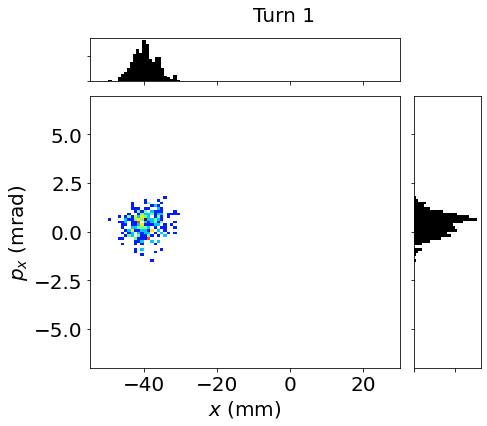

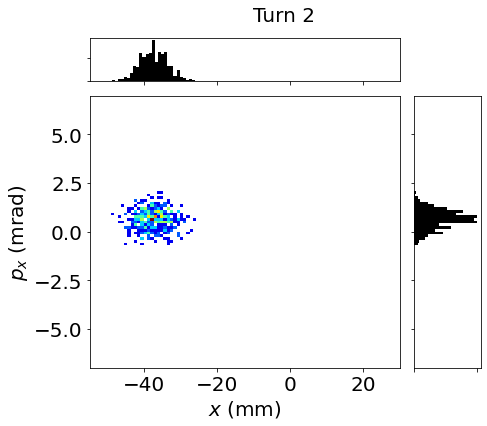

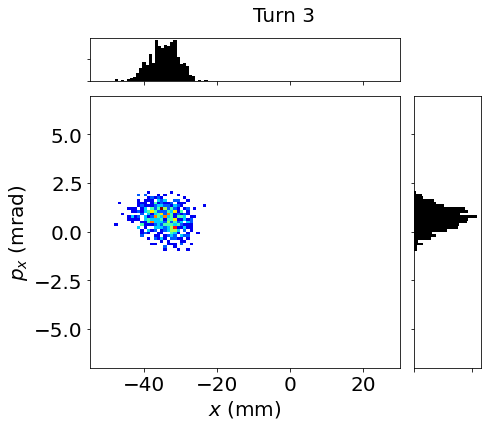

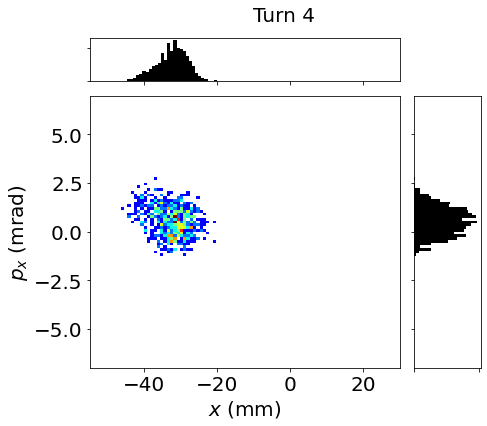

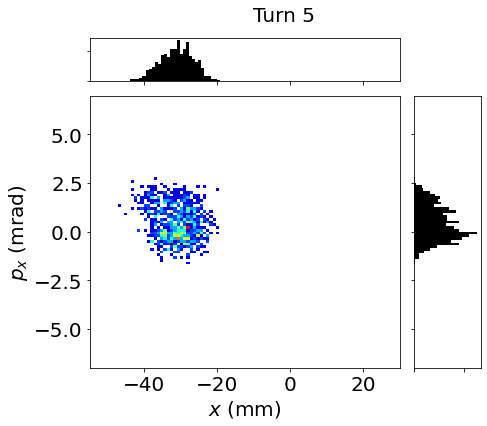

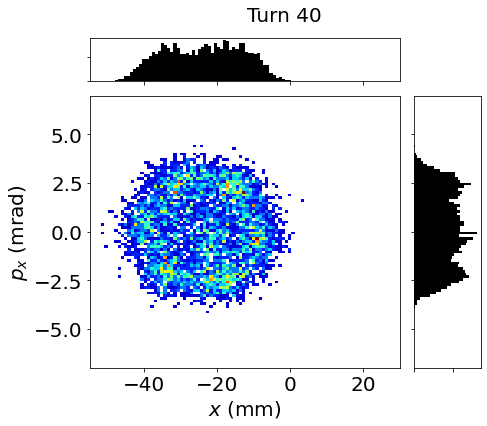

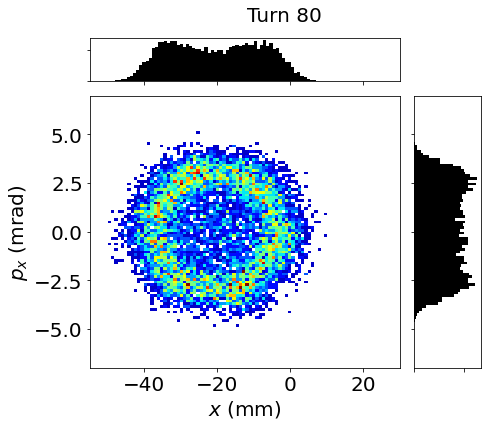

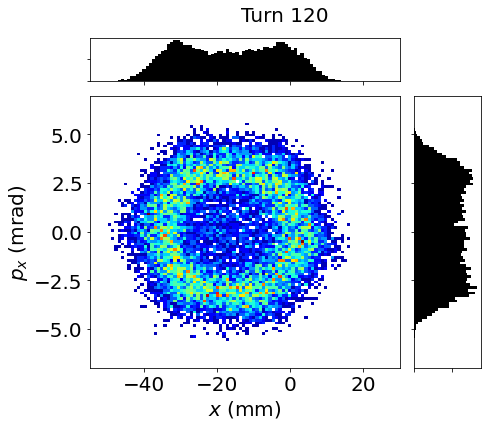

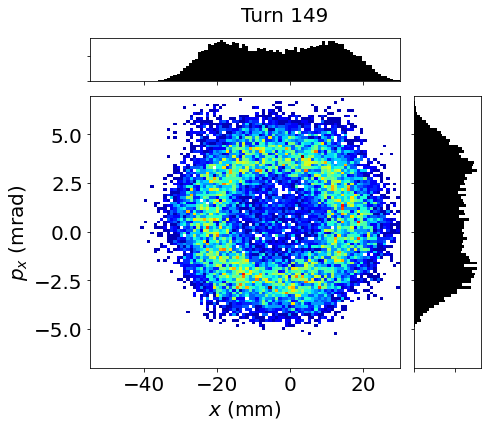

In [49]:
#for i in range(len(particles_x)):
#for i in range(0, 150, 20):
for i in [1,2,3,4,5, 40, 80, 120, 149]:

        turn=i

        my_cmap = plt.cm.jet
        my_cmap.set_under('w',1)
        fontsize=20
        bins = 100
        vmin = 0.1

        fig = plt.figure(figsize=(8,6), facecolor='white')
        gs = gridspec.GridSpec(6, 6)
        ax = plt.subplot(gs[1:6, 0:4])
        ax_xDist = plt.subplot(gs[0, 0:4],sharex=ax)
        ax_yDist = plt.subplot(gs[1:6, 4],sharey=ax)

        x = np.array(particles_x[i])
        px = np.array(particles_px[i])

        ax.hist2d(x*1e3, px*1e3,
                bins=bins, cmap = my_cmap, vmin=vmin, 
                #range=[[min(df.x)*1e3, max(df.x)*1e3], [min(df.px)*1e3, max(df.px)*1e3]]#, norm=mcolors.PowerNorm(gamma)
                range = [[-60, 30], [-7, 7]]
                )

        #r.plot_resonance(ax)
        ax.set_xlabel('$x$ (mm)', fontsize=fontsize)
        ax.set_ylabel('$p_x$ (mrad)', fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.set_xlim(-55, 30)
        ax.set_ylim(-7, 7)

        ax_xDist.hist(x*1e3,bins=bins,align='mid', color='black', range=(-55, 30))
        ax_xDist.tick_params(axis='x', labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax_xDist.tick_params(axis='y', labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        nsigmas = 2.5

        ax_yDist.hist(px*1e3,bins=bins,orientation='horizontal',align='mid', color='black', range=(-7, 7))
        ax_yDist.tick_params(axis='x', labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax_yDist.tick_params(axis='y', labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        nsigmas = 2.5

        plt.suptitle('Turn %s'%turn, fontsize=fontsize)
        fig.tight_layout()
        plt.show()